# Capstone Project - Restaurants of Austin
### Applied Data Science Capstone

## Table of contents

1. Introduction/Business Problem
2. Data
3. Methodology 
4. Results 
5. Discussion
6. Conclusion
7. References

### 1. Introduction

#### 1.1 Problem
The business problem is to get the count, pricing and rating of restaurants by zip codes in Austin. Map them based on each variable independently and then group them into clusters based on price and rating collectively to provide these details to residents and newcomers.

#### 1.2 Background and Interest
Austin is one of top growing cities, many families and businesses are relocating to the city. Some of the key information that the potential newcomers need is count, pricing and rating information of venues particularly restaurants in different neighborhoods of the city so that they can choose an area that fits their needs.

### 2. Data

#### 2.1 Data Collection
The required data that is needed for this problem is to first get all zip codes in Austin. Then get the restaurants in each zip code and finally get pricing and rating for each restaurant.
Opendatasoft will be used to get zip codes of Austin city along with latitude and longitude information and google places api will be used to get the restaurants in each zip code along with their pricing and rating.

#### 2.2 Data Cleaning	
It is convenient to download the zip codes data from opendatasoft in csv format. The csv is loaded into a pandas data frame and columns Zip, City, State, Longitude and Latitude are retained by dropping the columns that are not needed. 
For each zip code in above data frame, restaurants within 2500 m from the epicenter are queried. Restaurant name, location, price and rating are stored along with zip code information to a new data frame. Finally, the restaurants with no information for pricing and rating, and duplicates are dropped to get the clean data.

In [92]:
#import libraries

import numpy as np
import pandas as pd
import requests
import json
import time
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

### 3. Methodology
Methodology part is divided into 4 sections. In first section the data frame is analyzed by count, second section is based on pricing, third section uses rating for analysis, and finally pricing and rating are collectively used for clustering. 

In [38]:
#csv file is downloaded and saved locally is read into a dataframe

#url = 'https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=TX&q=Austin&timezone=America/Chicago&use_labels_for_header=true'
azll = pd.read_csv('austin-zip-code-latitude-and-longitude.csv', ';')
azll = azll.drop(['Timezone', 'Daylight savings time flag', 'geopoint'], axis=1)
azll.head()

,Zip,City,State,Latitude,Longitude
0,78727,Austin,TX,30.425652,-97.714190
1,78762,Austin,TX,30.326374,-97.771258
2,78763,Austin,TX,30.335398,-97.559807
3,78715,Austin,TX,30.450088,-97.486509
4,78745,Austin,TX,30.207559,-97.795750


Initially zip codes centers are mapped using Folium to visualize spreading of zip codes. Zip codes around the center of the city are closer and they are farther while moving away from the center of city.

In [93]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [94]:
# create map of Austin using latitude and longitude values
map_austin = folium.Map(location=[30.2672000, -97.7431000], zoom_start=10)

# add markers to map
for lat, lng, zipcode in zip(azll['Latitude'], azll['Longitude'], azll['Zip']):
    label = '{}'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  

map_austin

Data queried using places api is stored into a csv file to reduce repetitive querying and processing. Following is head of the data frame that is used for analysis. There are a total of 1130 restaurants within 46 zip codes in the cleaned data set.

In [41]:
clientId = ''
clientKey = ''

In [42]:
def getNearbyRestaurants(zipcodes, latitudes, longitudes, radius=2500):
    
    restaurants_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&radius={}&type=restaurant&key={}'.format(
            lat, 
            lng, 
            radius, 
            clientKey)
            
        # make the GET request
        response = requests.get(url).json()
        results = response["results"]
        
        while "next_page_token" in response.keys():
            time.sleep(2)
            npt = response["next_page_token"]
            npt_url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?pagetoken={}&key={}'.format(
                npt,
                clientKey)
            response = requests.get(npt_url).json()
            results += response["results"]

        for v in results:
            if 'price_level' in v.keys() and 'rating' in v.keys():
                # return only relevant information for each nearby venue
                restaurants_list.append([
                    zipcode, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['geometry']['location']['lat'], 
                    v['geometry']['location']['lng'],  
                    v['price_level'],
                    v['rating']])

    nearby_restaurants = pd.DataFrame(restaurants_list, columns=['Zip','Zip Latitude','Zip Longitude','Restaurant','Latitude','Longitude','Price','Rating'])
    return(nearby_restaurants)

In [43]:
#ar = getNearbyRestaurants(zipcodes=azll['Zip'], latitudes=azll['Latitude'], longitudes=azll['Longitude'])
#ar.to_csv('ar_out_2500.csv', index=False)

In [44]:
ar_df = pd.read_csv('ar_out_2500.csv', ',')
ar_df.head()

,Zip,Zip Latitude,Zip Longitude,Restaurant,Latitude,Longitude,Price,Rating
0,78727,30.425652,-97.71419,Tacodeli Gracy Farms,30.407702,-97.713286,1,4.6
1,78727,30.425652,-97.71419,Tomodachi Sushi,30.425470,-97.716920,2,4.6
2,78727,30.425652,-97.71419,Silver Grill Cafe,30.425090,-97.716169,1,3.8
3,78727,30.425652,-97.71419,P. Terry's Burger Stand,30.414557,-97.705283,1,4.4
4,78727,30.425652,-97.71419,Biryani Pot,30.417239,-97.704026,2,3.9


In [45]:
ar_cln = ar_df.drop_duplicates(subset=['Restaurant','Latitude','Longitude'], keep='first')
ar_cln.shape

(1130, 8)

#### 3.1 Count
Data is grouped by zip code, zip code’s latitude, zip code’s longitude and count of all restaurants in the zip code. 


In [95]:
ar_count = ar_cln.groupby(['Zip', 'Zip Latitude', 'Zip Longitude']).size().reset_index()
ar_count.head()

,Zip,Zip Latitude,Zip Longitude,0
0,78701,30.271270,-97.74103,58
1,78702,30.265158,-97.71879,22
2,78703,30.290907,-97.76277,26
3,78704,30.246309,-97.76087,48
4,78705,30.292424,-97.73856,48


#### 3.1.1 Count Map
The range of count is 0 to 60, it is divided into 6 equal parts. Each zip code is mapped with color that matches to count of restaurants in the zip code. Map shows that the zip codes near center of city and zip codes near north and south west with more offices and residences have higher count of restaurants and the count decreases as we move further away from those. This corelates well with the fact that the downtown and places with denser population that have more offices and residences also have higher number of restaurants.


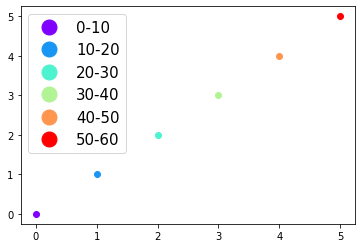

In [96]:
# Generate a range for colors and legend for range using matplotlib
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, 6))
rainbow = [colors.rgb2hex(i) for i in colors_array]

labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60']
for i in x:
    plt.plot(i, i, 'o', c=rainbow[i], label=labels[i])
lgnd = plt.legend(loc=2, prop={'size': 15})
for handle in lgnd.legendHandles:
    handle._legmarker.set_markersize(15)

In [99]:
# create map
map_count = folium.Map(location=[30.2672000, -97.7431000], zoom_start=10)

# add markers to the map
markers_colors = []
for lt, ln, zp, sz in zip(ar_count['Zip Latitude'], ar_count['Zip Longitude'], ar_count['Zip'], ar_count[0]):
    if not math.isnan(sz):
        label = folium.Popup(' Zip ' + str(zp) + ' Count ' + str(round(sz)), parse_html=True)
        folium.CircleMarker(
            [lt, ln],
            radius=5,
            popup=label,
            color=rainbow[int(sz/10)],
            fill=True,
            fill_color=rainbow[int(sz/10)],
            fill_opacity=0.7).add_to(map_count)
       
map_count

#### 3.2 Pricing
Data is grouped by zip code, zip code’s latitude, zip code’s longitude and mean pricing of all restaurants in the zip code. Pricing for a venue is divided into 4 levels in google places where higher the level, more expensive is the restaurant. Each restaurant has one of the four levels for pricing, we use level itself as pricing for simplifying analysis and take the mean to show overall pricing for the neighborhood.  

In [100]:
ar_price_mean = ar_cln.groupby(['Zip', 'Zip Latitude', 'Zip Longitude']).mean()[['Price']]
ar_price_mean = ar_price_mean.reset_index()
ar_price_mean.head()

,Zip,Zip Latitude,Zip Longitude,Price
0,78701,30.271270,-97.74103,1.982759
1,78702,30.265158,-97.71879,1.909091
2,78703,30.290907,-97.76277,1.769231
3,78704,30.246309,-97.76087,1.625000
4,78705,30.292424,-97.73856,1.520833


#### 3.2.1 Pricing Map
The grouped data is mapped using folium. Each zip code center is colored by mean pricing. Since most restaurants in all zip codes have pricing levels 1 and 2, mean pricing is in that range. 

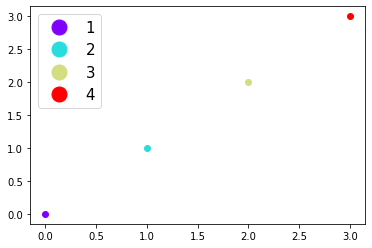

In [101]:
# Generate a range for colors and legend for range using matplotlib
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, 4))
rainbow = [colors.rgb2hex(i) for i in colors_array]

labels = ['1', '2', '3', '4']
for i in x:
    plt.plot(i, i, 'o', c=rainbow[i], label=labels[i])
lgnd = plt.legend(loc=2, prop={'size': 15})
for handle in lgnd.legendHandles:
    handle._legmarker.set_markersize(15)

Again, it clearly shows that the restaurants near downtown and within few well-off suburbs have higher pricing. This gives a very clear picture of the distribution of pricing of restaurants.

In [102]:
# create map
map_prices = folium.Map(location=[30.2672000, -97.7431000], zoom_start=10)

# add markers to the map
markers_colors = []
for lt, ln, zp, pr in zip(ar_price_mean['Zip Latitude'], ar_price_mean['Zip Longitude'], ar_price_mean['Zip'], ar_price_mean['Price']):
    if not math.isnan(pr):
        label = folium.Popup(' Zip ' + str(zp) + ' Price ' + str(round(pr)), parse_html=True)
        folium.CircleMarker(
            [lt, ln],
            radius=5,
            popup=label,
            color=rainbow[int(round(pr))-1],
            fill=True,
            fill_color=rainbow[int(round(pr))-1],
            fill_opacity=0.7).add_to(map_prices)
       
map_prices

#### 3.3 Rating
Data is grouped by zip code, zip code’s latitude, zip code’s longitude and mean ratings of all restaurants in the zip code. Rating for a restaurant has a range of 0 to 5 but the range of mean ratings in grouped data is 3.3 to 4.5. The difference between zip codes based on rating is less than it was based on pricing or count.


In [103]:
ar_rating_mean = ar_cln.groupby(['Zip', 'Zip Latitude', 'Zip Longitude']).mean()[['Rating']]
ar_rating_mean = ar_rating_mean.reset_index()
ar_rating_mean.head()

,Zip,Zip Latitude,Zip Longitude,Rating
0,78701,30.271270,-97.74103,4.348276
1,78702,30.265158,-97.71879,4.386364
2,78703,30.290907,-97.76277,4.192308
3,78704,30.246309,-97.76087,4.285417
4,78705,30.292424,-97.73856,4.281250


#### 3.3.1 Rating Map
Small padding is added to the range to set it from 3.2 to 4.6 and it is divided into 7 equal parts. Zip codes are mapped with a color based of mean rating and the range described above. Though the difference based on rating is not as segregating as it was based on pricing it too shows that zip codes near downtown, north and east of the city have more rating than the ones on the west and south.

In [104]:
#finding max, min and range of mean rating
max_rt = round(ar_rating_mean['Rating'].max(),1)
min_rt = round(ar_rating_mean['Rating'].min(),1)
rng_rt = round(max_rt - min_rt,1)
print('rating  max -', max_rt, 'min -', min_rt, 'range -', rng_rt)

rating  max - 4.5 min - 3.3 range - 1.2


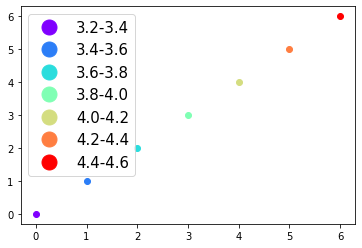

In [105]:
# Generate a range for colors and legend for range using matplotlib
x = np.arange(7)
ys = [i + x + (i*x)**2 for i in range(7)]
colors_array = cm.rainbow(np.linspace(0, 1, 7))
rainbow = [colors.rgb2hex(i) for i in colors_array]

labels = ['3.2-3.4', '3.4-3.6', '3.6-3.8', '3.8-4.0', '4.0-4.2', '4.2-4.4', '4.4-4.6']
for i in x:
    plt.plot(i, i, 'o', c=rainbow[i], label=labels[i])
lgnd = plt.legend(loc=2, prop={'size': 15})
for handle in lgnd.legendHandles:
    handle._legmarker.set_markersize(15)

In [106]:
# create map
map_ratings = folium.Map(location=[30.2672000, -97.7431000], zoom_start=10)

# add markers to the map
markers_colors = []
for lt, ln, zp, rt in zip(ar_rating_mean['Zip Latitude'], ar_rating_mean['Zip Longitude'], ar_rating_mean['Zip'], ar_rating_mean['Rating']):
    if not math.isnan(rt):
        rrt = round(rt,1)
        label = folium.Popup(' Zip ' + str(zp) + ' Rating ' + str(round(rrt,1)), parse_html=True)
        folium.CircleMarker(
            [lt, ln],
            radius=5,
            popup=label,
            color=rainbow[int(round((rrt-3.2)*7/1.4,1))],
            fill=True,
            fill_color=rainbow[int(round((rrt-3.2)*7/1.4,1))],
            fill_opacity=0.7).add_to(map_ratings)
       
map_ratings

#### 3.4 Clustering
Data frames created from grouping by pricing and rating are merged to create a single data frame with both mean pricing and rating for each zip code that is used for clustering.

In [86]:
ar_mean_merged = pd.merge(ar_price_mean, ar_rating_mean, on=['Zip', 'Zip Latitude', 'Zip Longitude'], how='outer')
ar_mean_merged.head()

,Zip,Zip Latitude,Zip Longitude,Price,Rating
0,78701,30.271270,-97.74103,1.982759,4.348276
1,78702,30.265158,-97.71879,1.909091,4.386364
2,78703,30.290907,-97.76277,1.769231,4.192308
3,78704,30.246309,-97.76087,1.625000,4.285417
4,78705,30.292424,-97.73856,1.520833,4.281250


#### 3.4.1 K-means Clustering
Zip code, zip code latitude and zip code longitude columns are dropped from the data frame to create a new data frame with only pricing and rating columns that are passed to the k-means fit. Number of clusters for k-means is set to 5 which is close to number of pricing levels 4 and rating range 0 to 5. 

In [107]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters_mean = 5

ar_mean_clustering = ar_mean_merged.drop(['Zip', 'Zip Latitude', 'Zip Longitude'], 1)

# run k-means clustering
kmeans_means = KMeans(n_clusters=kclusters_mean, random_state=0).fit(ar_mean_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_means.labels_

array([1, 1, 1, 1, 4, 4, 4, 4, 2, 0, 3, 0, 3, 4, 0, 0, 1, 1, 3, 1, 0, 3,
       3, 4, 0, 0, 2, 0, 4, 2, 0, 4, 4, 4, 4, 0, 1, 0, 0, 1, 4, 0, 0, 0,
       4, 2])

### 4. Results
Zip codes are mapped with cluster labels as color. Clustering results are comparable to results from grouping by count, pricing and rating independently. Clearly the zip codes closer to downtown, north and east side of the city are clustered in similar groups and those farther away from downtown, east and south side of city are grouped into alike clusters. Clusters show that well-off neighborhoods are similarly grouped which consist of restaurants that have good ratings and higher price levels.

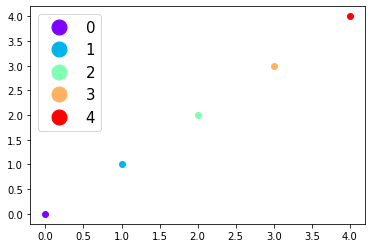

In [110]:
x = np.arange(kclusters_mean)
ys = [i + x + (i*x)**2 for i in range(kclusters_mean)]
colors_array = cm.rainbow(np.linspace(0, 1, kclusters_mean))
rainbow = [colors.rgb2hex(i) for i in colors_array]

labels = ['0', '1', '2', '3', '4']
for i in x:
    plt.plot(i, i, 'o', c=rainbow[i], label=labels[i])
lgnd = plt.legend(loc=2, prop={'size': 15})
for handle in lgnd.legendHandles:
    handle._legmarker.set_markersize(15)

In [111]:
# create map
map_clusters = folium.Map(location=[30.2672000, -97.7431000], zoom_start=10)

# add markers to the map
markers_colors = []
for lt, ln, zp, cl in zip(ar_mean_merged['Zip Latitude'], ar_mean_merged['Zip Longitude'], ar_mean_merged['Zip'], kmeans_means.labels_):
    if not math.isnan(cl):
        label = folium.Popup(str(zp) + ' Cluster ' + str(cl), parse_html=True)
        folium.CircleMarker(
            [lt, ln],
            radius=5,
            popup=label,
            color=rainbow[int(cl)-1],
            fill=True,
            fill_color=rainbow[int(cl)-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5. Discussion
Quality and quantity of data collected was enough to do the analysis and get the results needed to answer the problem. There was good number of restaurants within each zip code to provide effective average for price and rating. This allowed to generate good maps that clearly grouped the zip codes based off count, pricing and rating.

Division among zip codes based on count gives residents who dine out frequently to choose a neighborhood with higher number of restaurants. Grouping by pricing provides residents option to select a neighborhood that fits their budget and grouping by rating provides all with data needed to filter out ones that aren’t good. Finally clustering based on both pricing and rating provides users exactly neighborhoods that fits their budget and has good ratings.

All groupings and clustering show consistently that the downtown area which is quite popular for several things is also the best option for restaurant goers. Second option are the neighborhoods that are towards north and south east which are newly developing neighborhoods. And the ones on east side farther away from city are to be avoided as they have consistently ranked lower on every grouping and clustering.

### 6.	Conclusion
New relocators and current residents looking for several good restaurants, downtown, couple of neighborhoods in north and south east are the best neighborhoods, which are also good neighborhoods based on several other factors.

### 7.	Refernces
• [1] OpenDataSoft- https://public.opendatasoft.com

• [2] Google Places API -  https://maps.googleapis.com/maps/api/place
